<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>k-core decomposition</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
np.random.seed(123)

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D

import seaborn as sns

from ipywidgets import interact
import networkx as nx

import os
import gzip

import tqdm as tq
from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by printing out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

Compiler    : Clang 15.0.0 (clang-1500.1.0.2.5)
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 744f3f098fc2a7f878aa1b306ca3dd802cafaffb

json      : 2.0.9
watermark : 2.4.3
numpy     : 1.26.4
tqdm      : 4.66.1
networkx  : 3.2.1
matplotlib: 3.8.2
pandas    : 2.2.0
seaborn   : 0.13.2



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# k-Core decomposition

We can extract a given core using this short snippet

In [4]:
def remove_core(G_orig, core):
    remove = None
    G = G_orig.copy()
    core_nodes = []
    
    while remove is None or len(remove) > 0:            
        deg = G.degree()
        remove = [node for node, degree in deg if degree <= core]
        G.remove_nodes_from(remove)
        core_nodes.extend(remove)
        
    return G, core_nodes

which when applied for every value of $k$ gives us the $k$-core decomposition of the graph

In [5]:
def kcore_number(G_orig):
    G = G_orig.copy()
    core_numbers = {}
    
    core = 0
    
    # Stop when there are no mre nodes
    while G.number_of_nodes() > 0:
        core += 1
        G, core_nodes = remove_core(G, core)
        core_numbers.update({node:core for node in core_nodes})
    
    return core_numbers

## Karate Club graph

Let's use the venerable Karate Club graph as a toy example

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


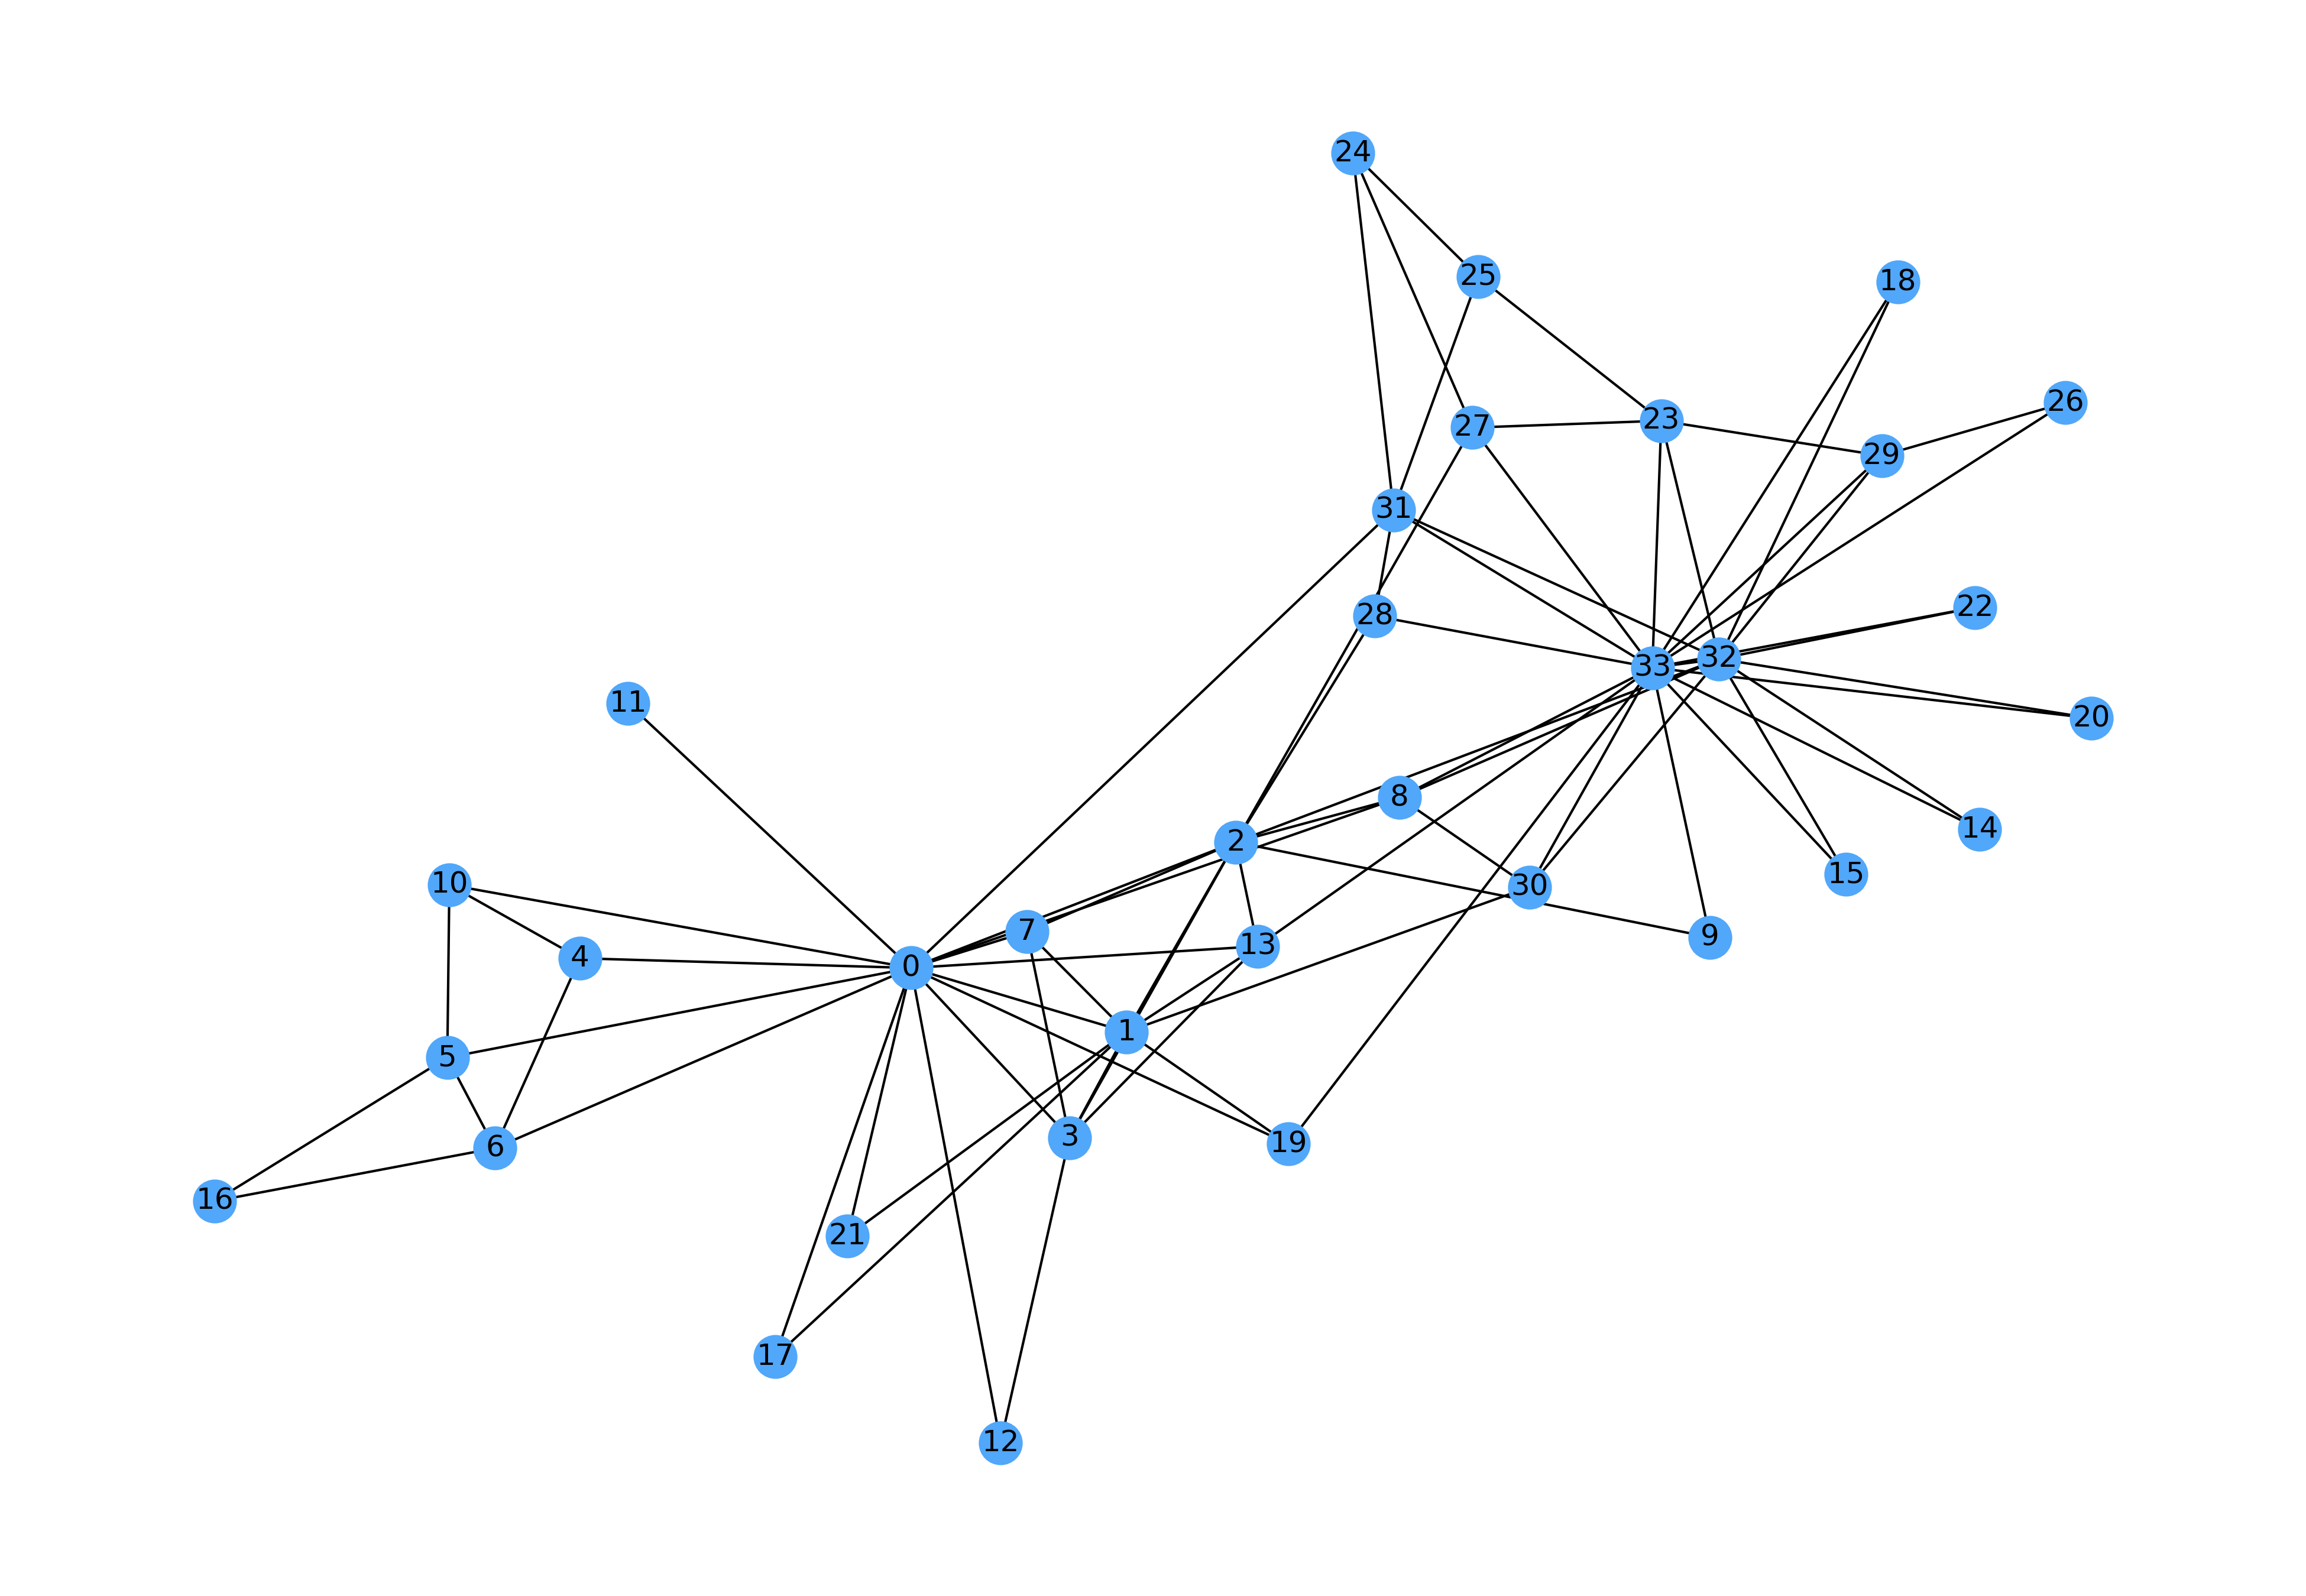

In [6]:
G = nx.karate_club_graph()
np.random.seed(123)
layout = nx.layout.spring_layout(G)
nx.draw(G, pos=layout, with_labels = True, node_color=colors[0])

Compute the core number for each node

In [7]:
core_numbers = nx.core_number(G)

And replot the network with the nodes colored by k-core

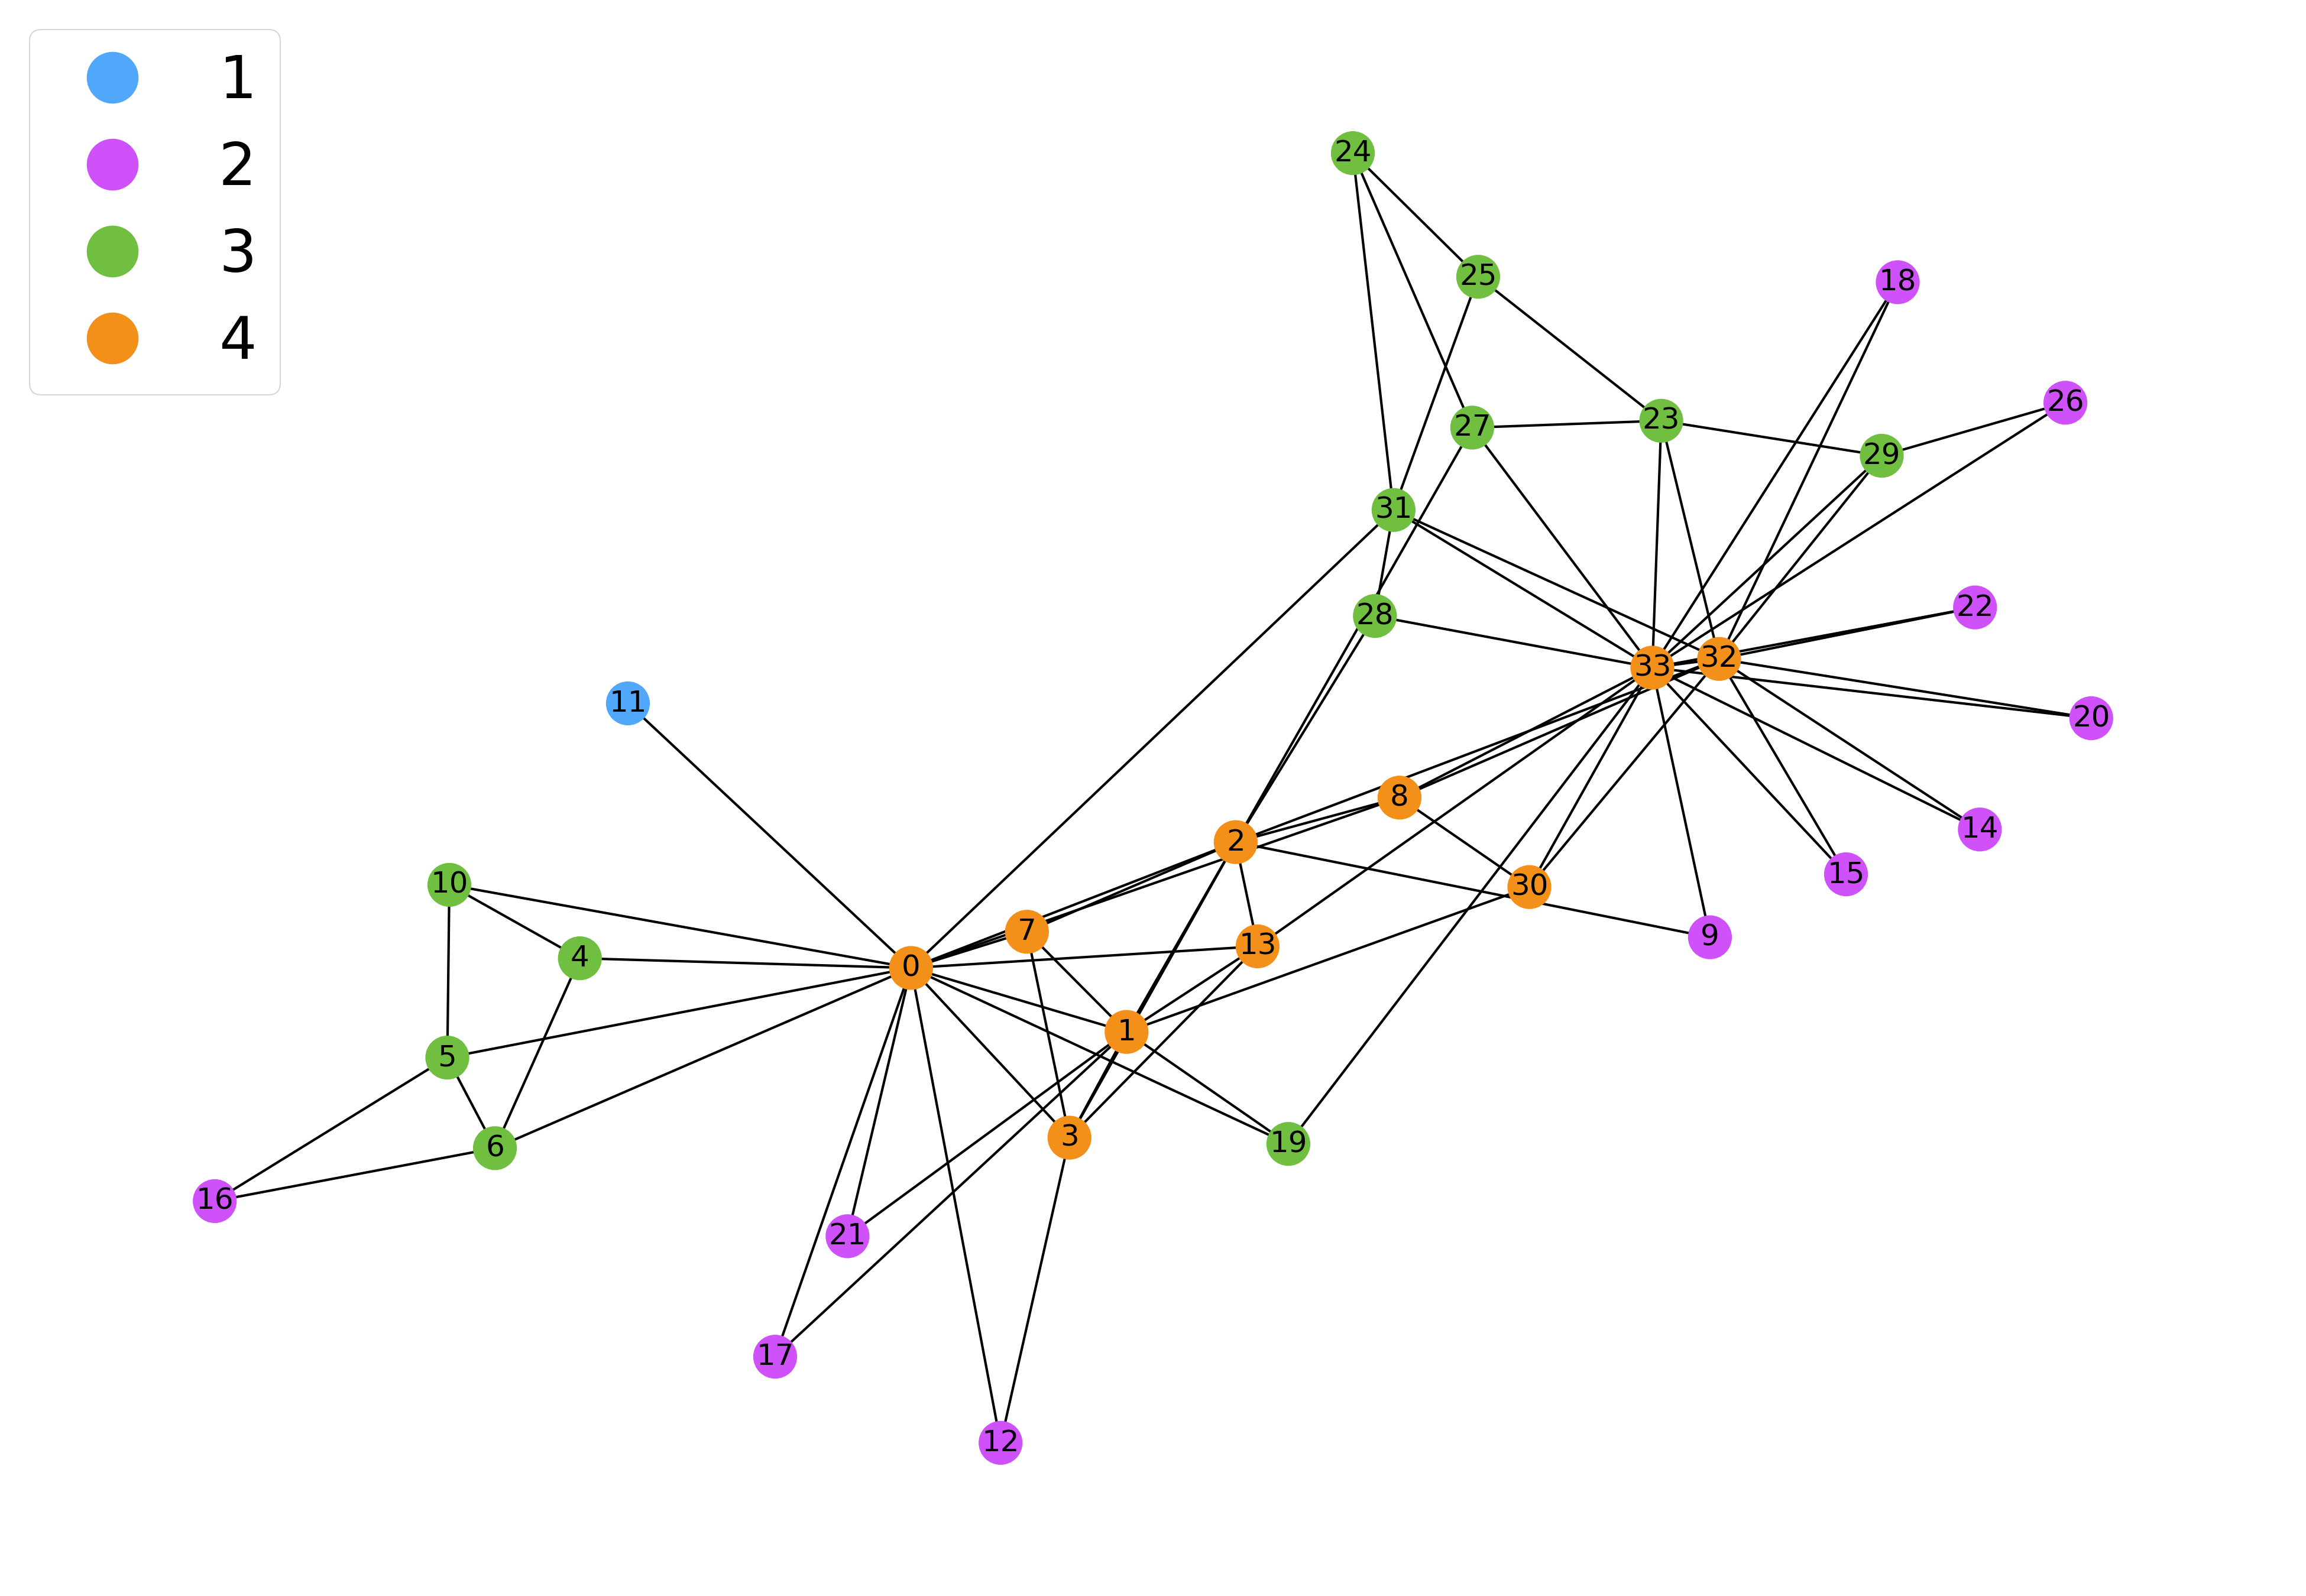

In [8]:
karate_colors = [colors[core_numbers[node]-1] for node, core in core_numbers.items()]

nx.draw(G, pos=layout, with_labels = True, node_color=karate_colors)
ax = plt.gca()
fig = plt.gcf()

handles, labels = ax.get_legend_handles_labels()
cores = max(core_numbers.values())
for core in range(cores):
    core_legend = Line2D([0], [0], label=core+1, marker='o', markersize=20, 
         markerfacecolor=colors[core], markeredgecolor=colors[core], linestyle='')
    handles.append(core_legend)
    
fig.legend(handles=handles, loc='upper left')

## Barabasi-Albert Graph

We start by generating a tree-like BA graph

In [9]:
G = nx.barabasi_albert_graph(1000, 1)
np.random.seed(1337)
layout = nx.layout.kamada_kawai_layout(G)

and confirm that it is indeed a tree

In [10]:
nx.is_tree(G)

True

We can reshuffle the edges of this graph while preserving the degree of each node

In [11]:
G2 = nx.double_edge_swap(G.copy(), 10*G.number_of_nodes(), 20*G.number_of_nodes())

And verify that the degree distribution is indeed the same. We start by extracting the degree of each node

In [12]:
deg = pd.DataFrame.from_dict(dict(G.degree()), orient='index', columns=['k'])
deg2 = pd.DataFrame.from_dict(dict(G2.degree()), orient='index', columns=['k'])
total = deg.join(deg2, rsuffix='_reshuffled', lsuffix='_original')

Computing the degree distributions

In [13]:
dist = pd.DataFrame(Counter(total.k_original.tolist()).items())
dist2 = pd.DataFrame(Counter(total.k_reshuffled.tolist()).items())

and plot them

(0.8, 1000)

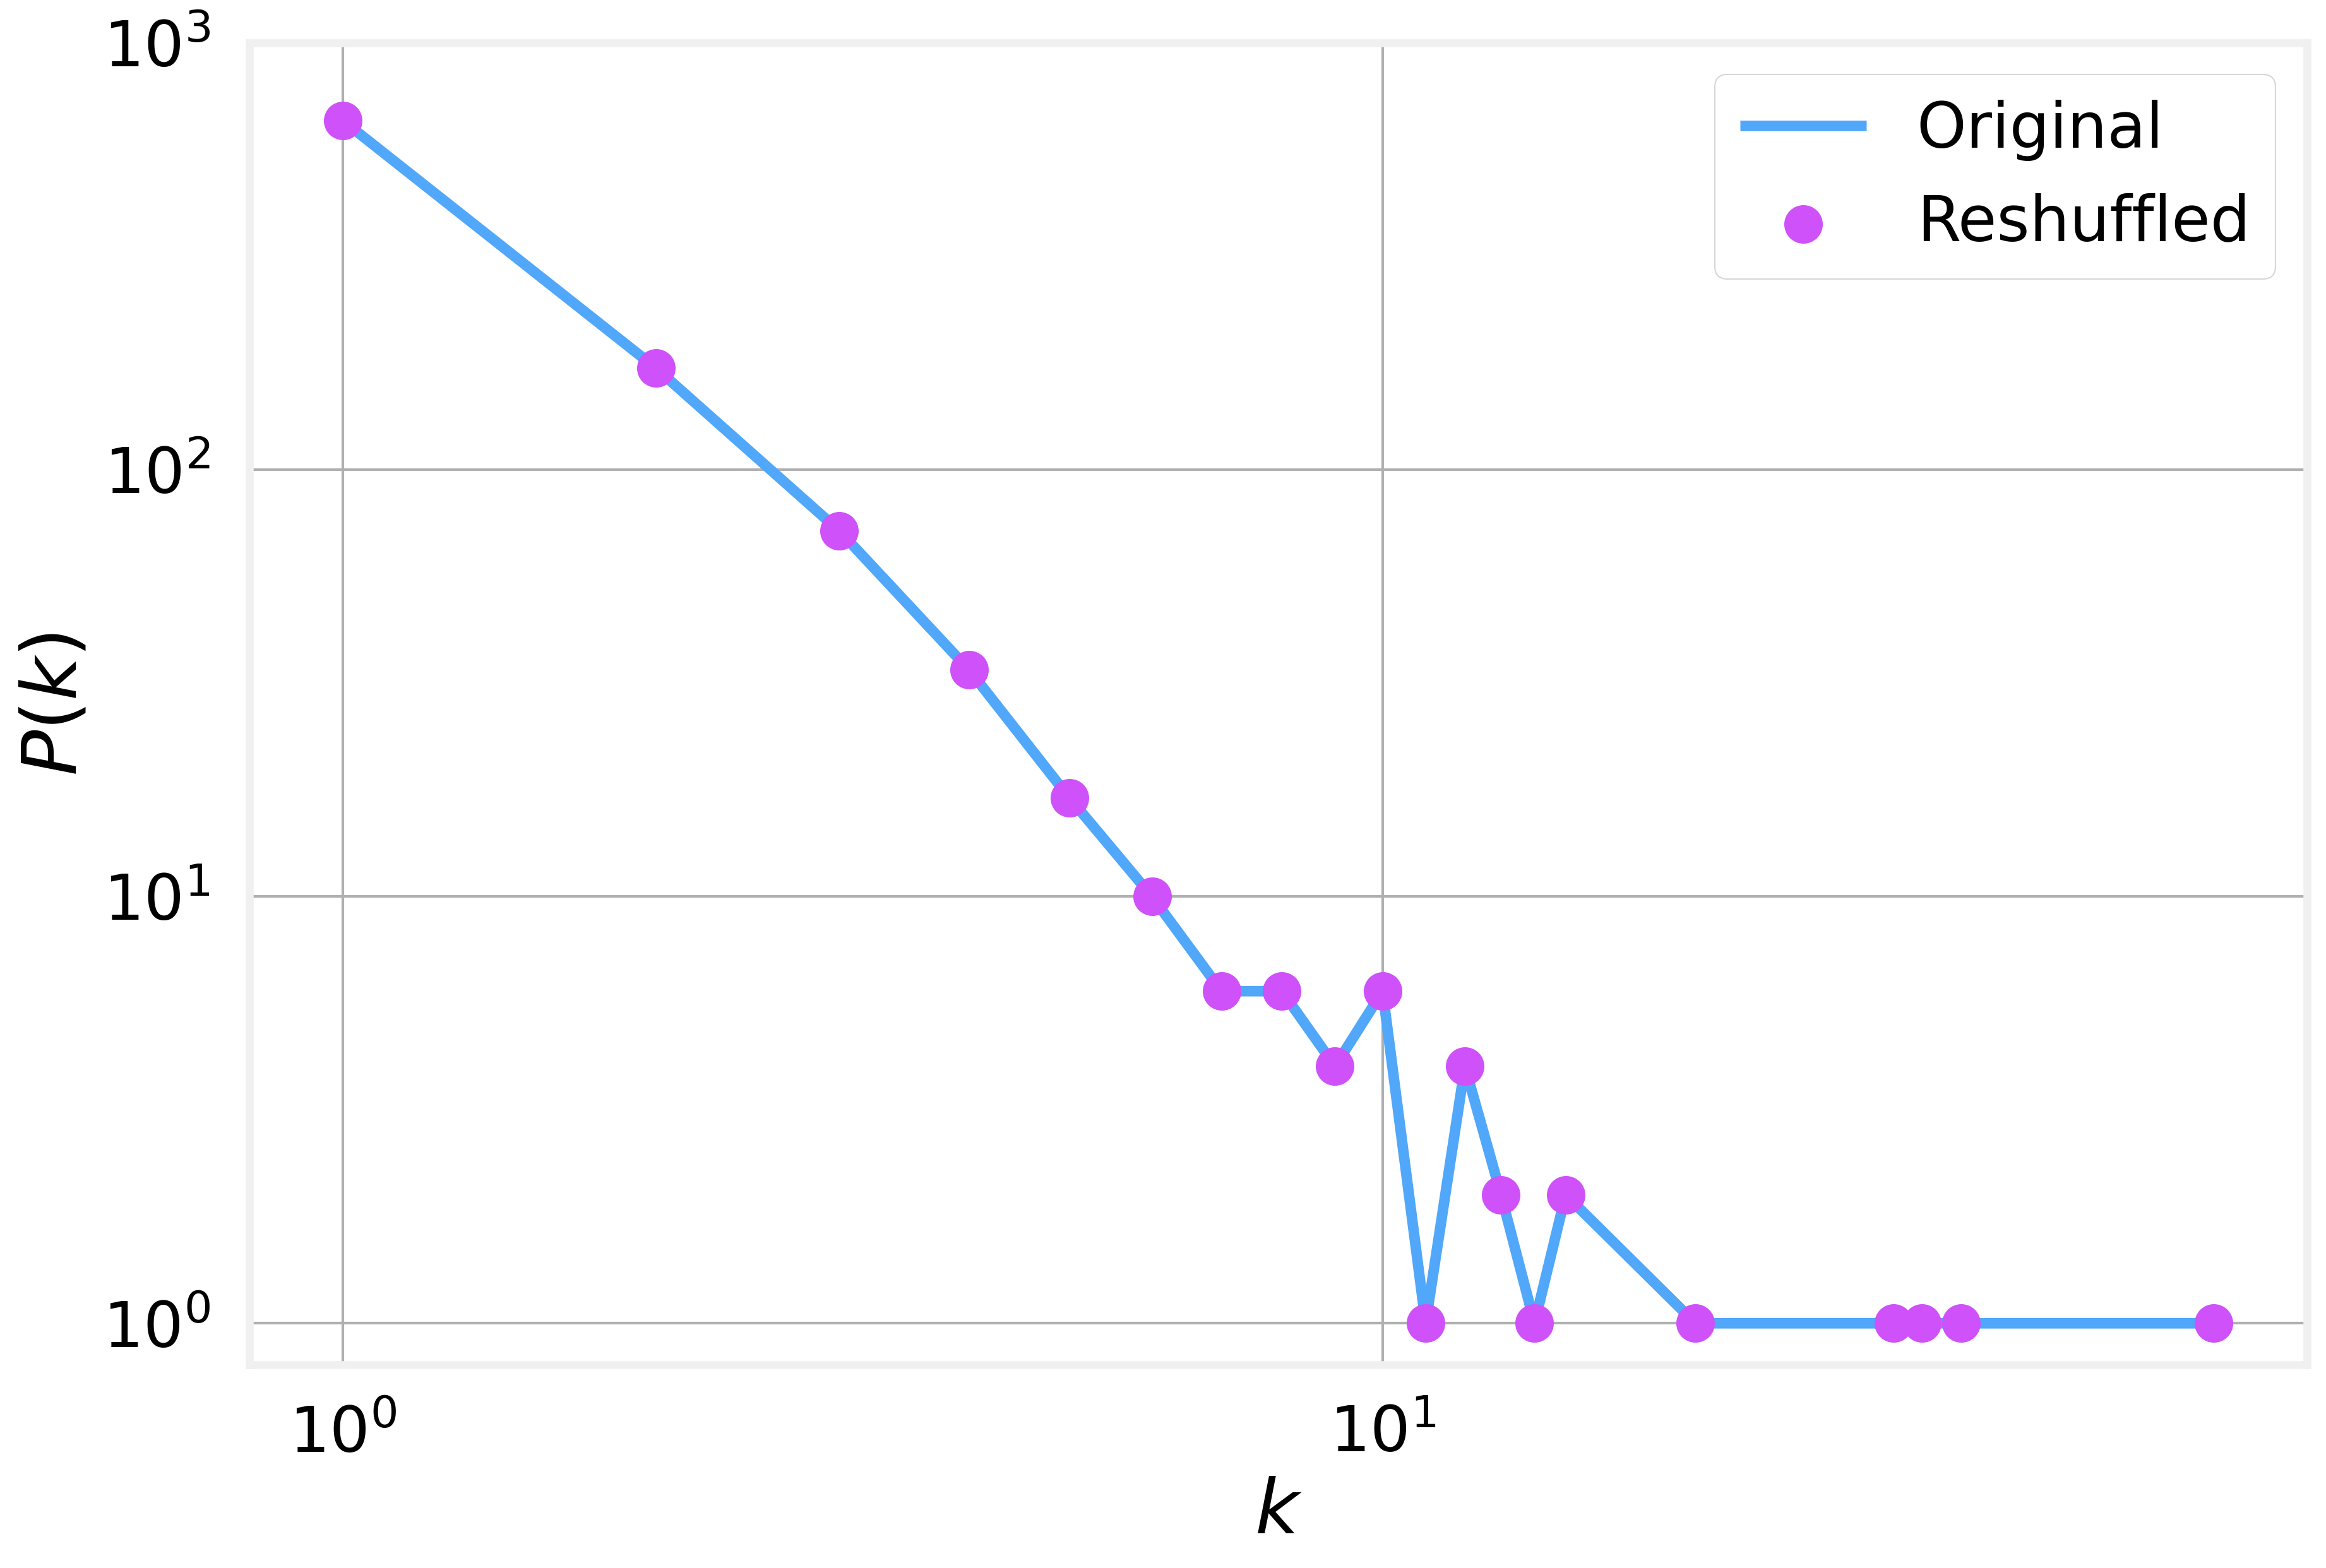

In [14]:
ax = dist.sort_values(0).plot(x=0, y=1, legend=None)
dist2.sort_values(0).plot.scatter(x=0, y=1, legend=None, 
                                  ax=ax, color=colors[1], 
                                  s=200, zorder=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(['Original', 'Reshuffled'])
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P\left(k\right)$')
ax.tick_params(direction='out', pad=15)
ax.set_ylim(.8, 1000)

We can also plot the two graphs side by side to verify that while the degree of each node is the same, the actual structure of the graph is very different

Text(0.5, 1.0, 'Reshuffled')

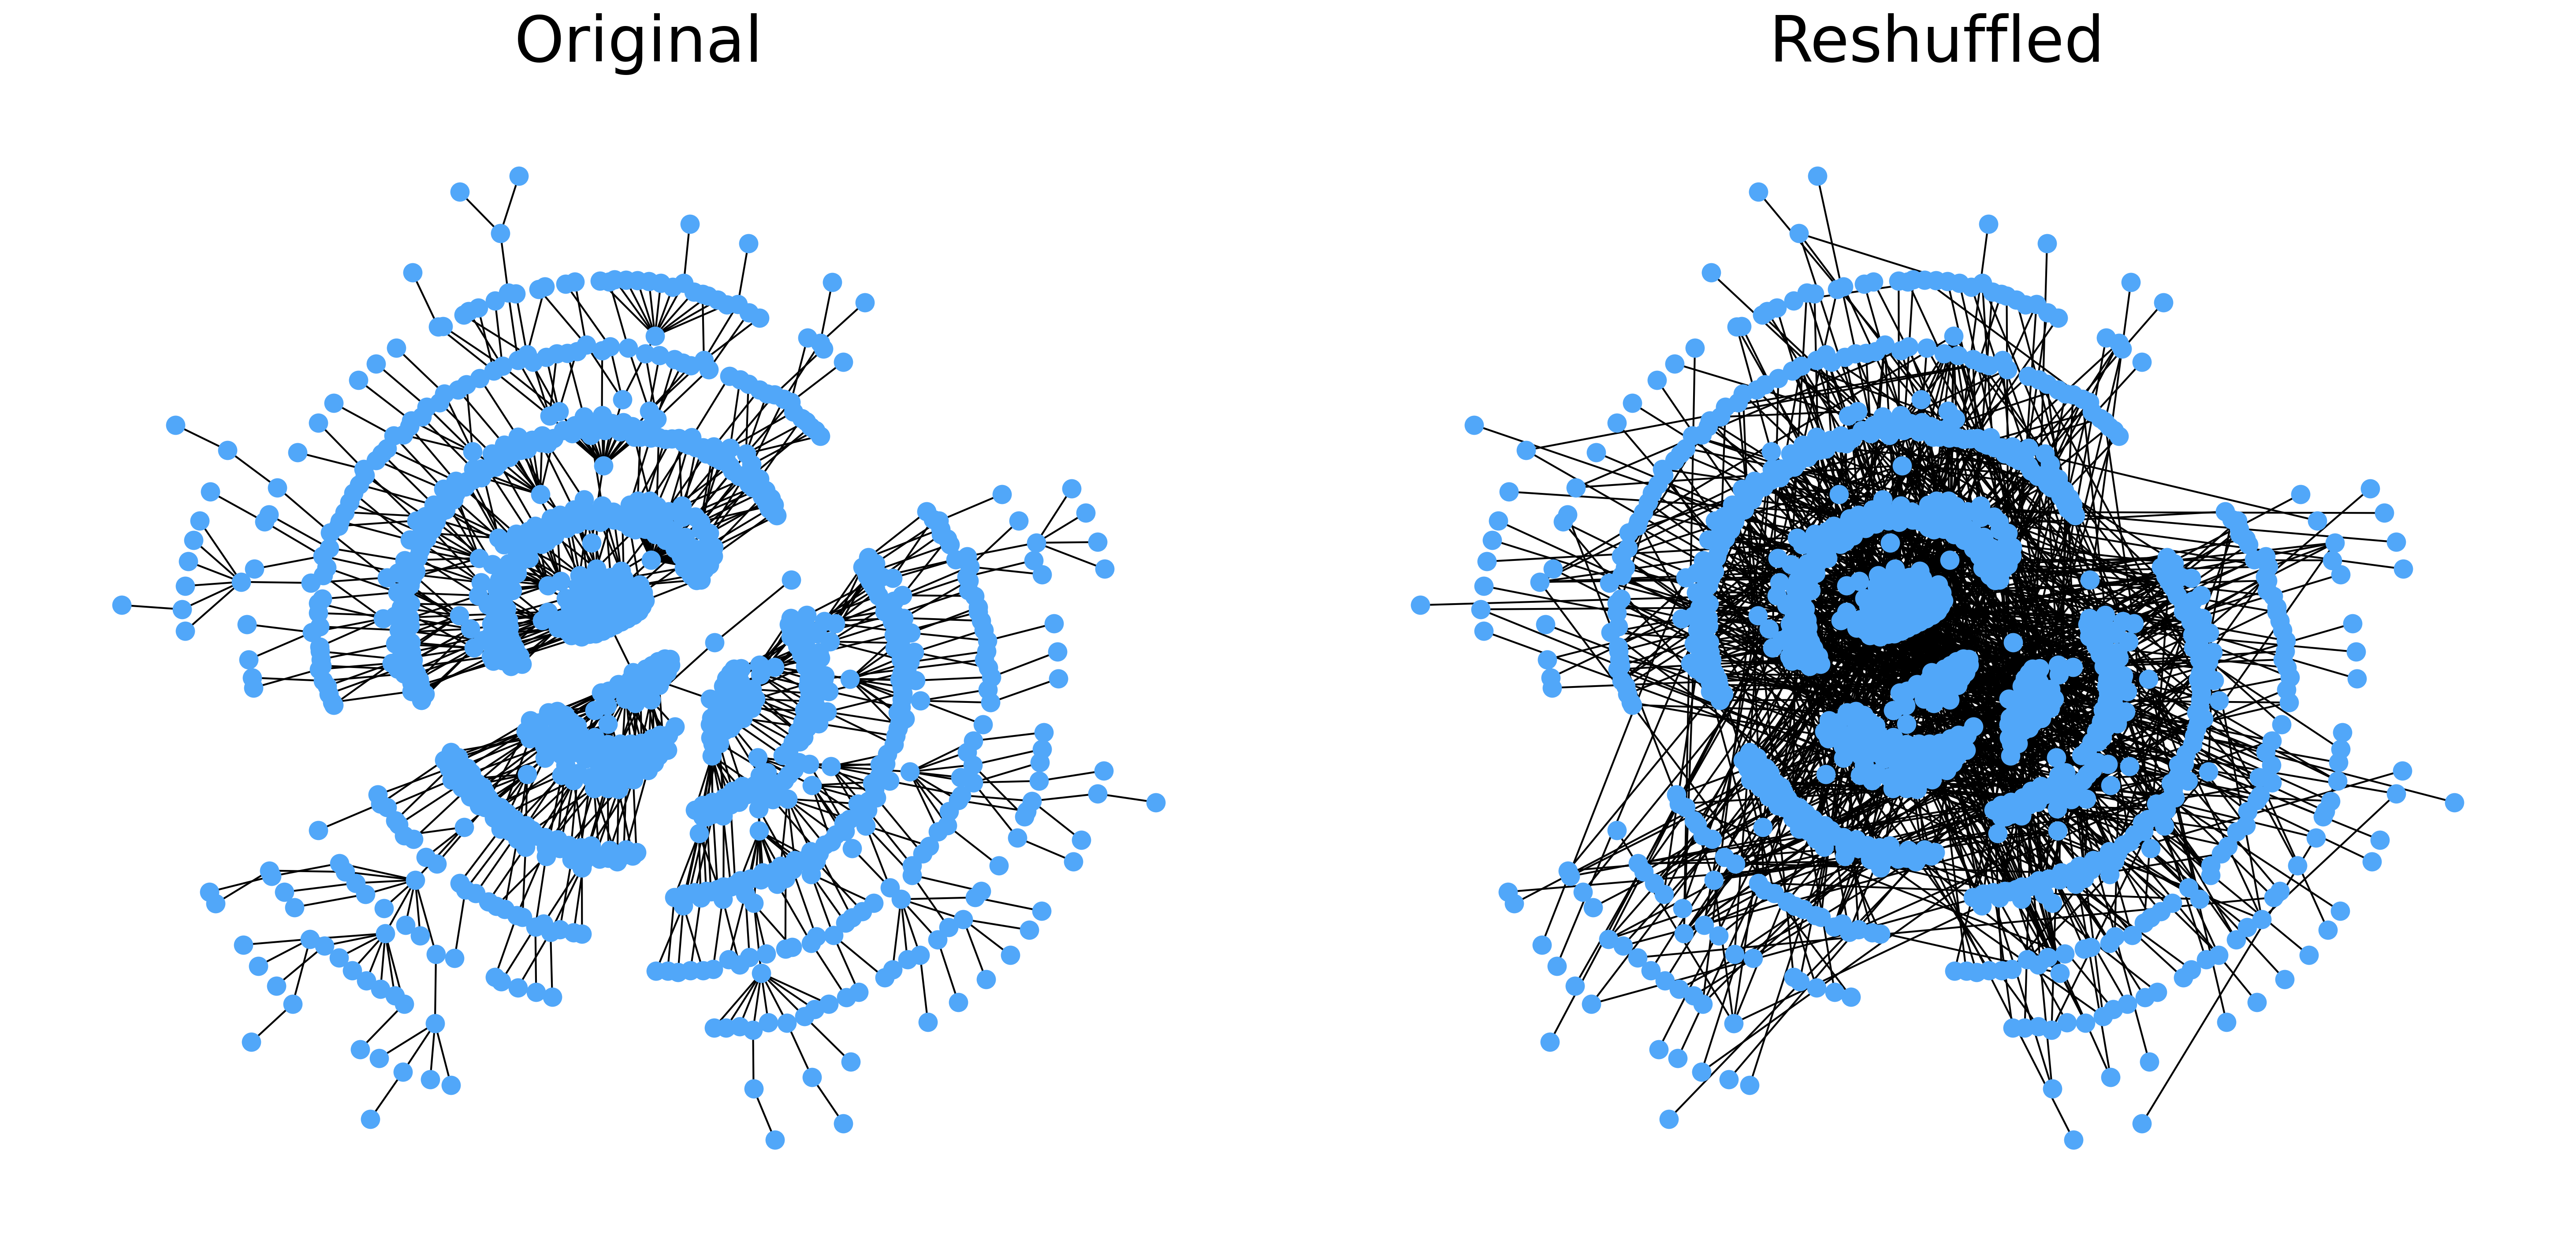

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G, pos=layout, ax=axs[0], node_size=100, node_color=colors[0])
nx.draw(G2, pos=layout, ax=axs[1], node_size=100, node_color=colors[0])
axs[0].set_title('Original')
axs[1].set_title('Reshuffled')

In [16]:
core_numbers = kcore_number(G)
core_numbers2 = kcore_number(G2)

In [17]:
original_colors = []
reshuffled_colors = []

for node in G.nodes():
    original_colors.append(colors[core_numbers[node]-1])
    reshuffled_colors.append(colors[core_numbers2[node]-1])

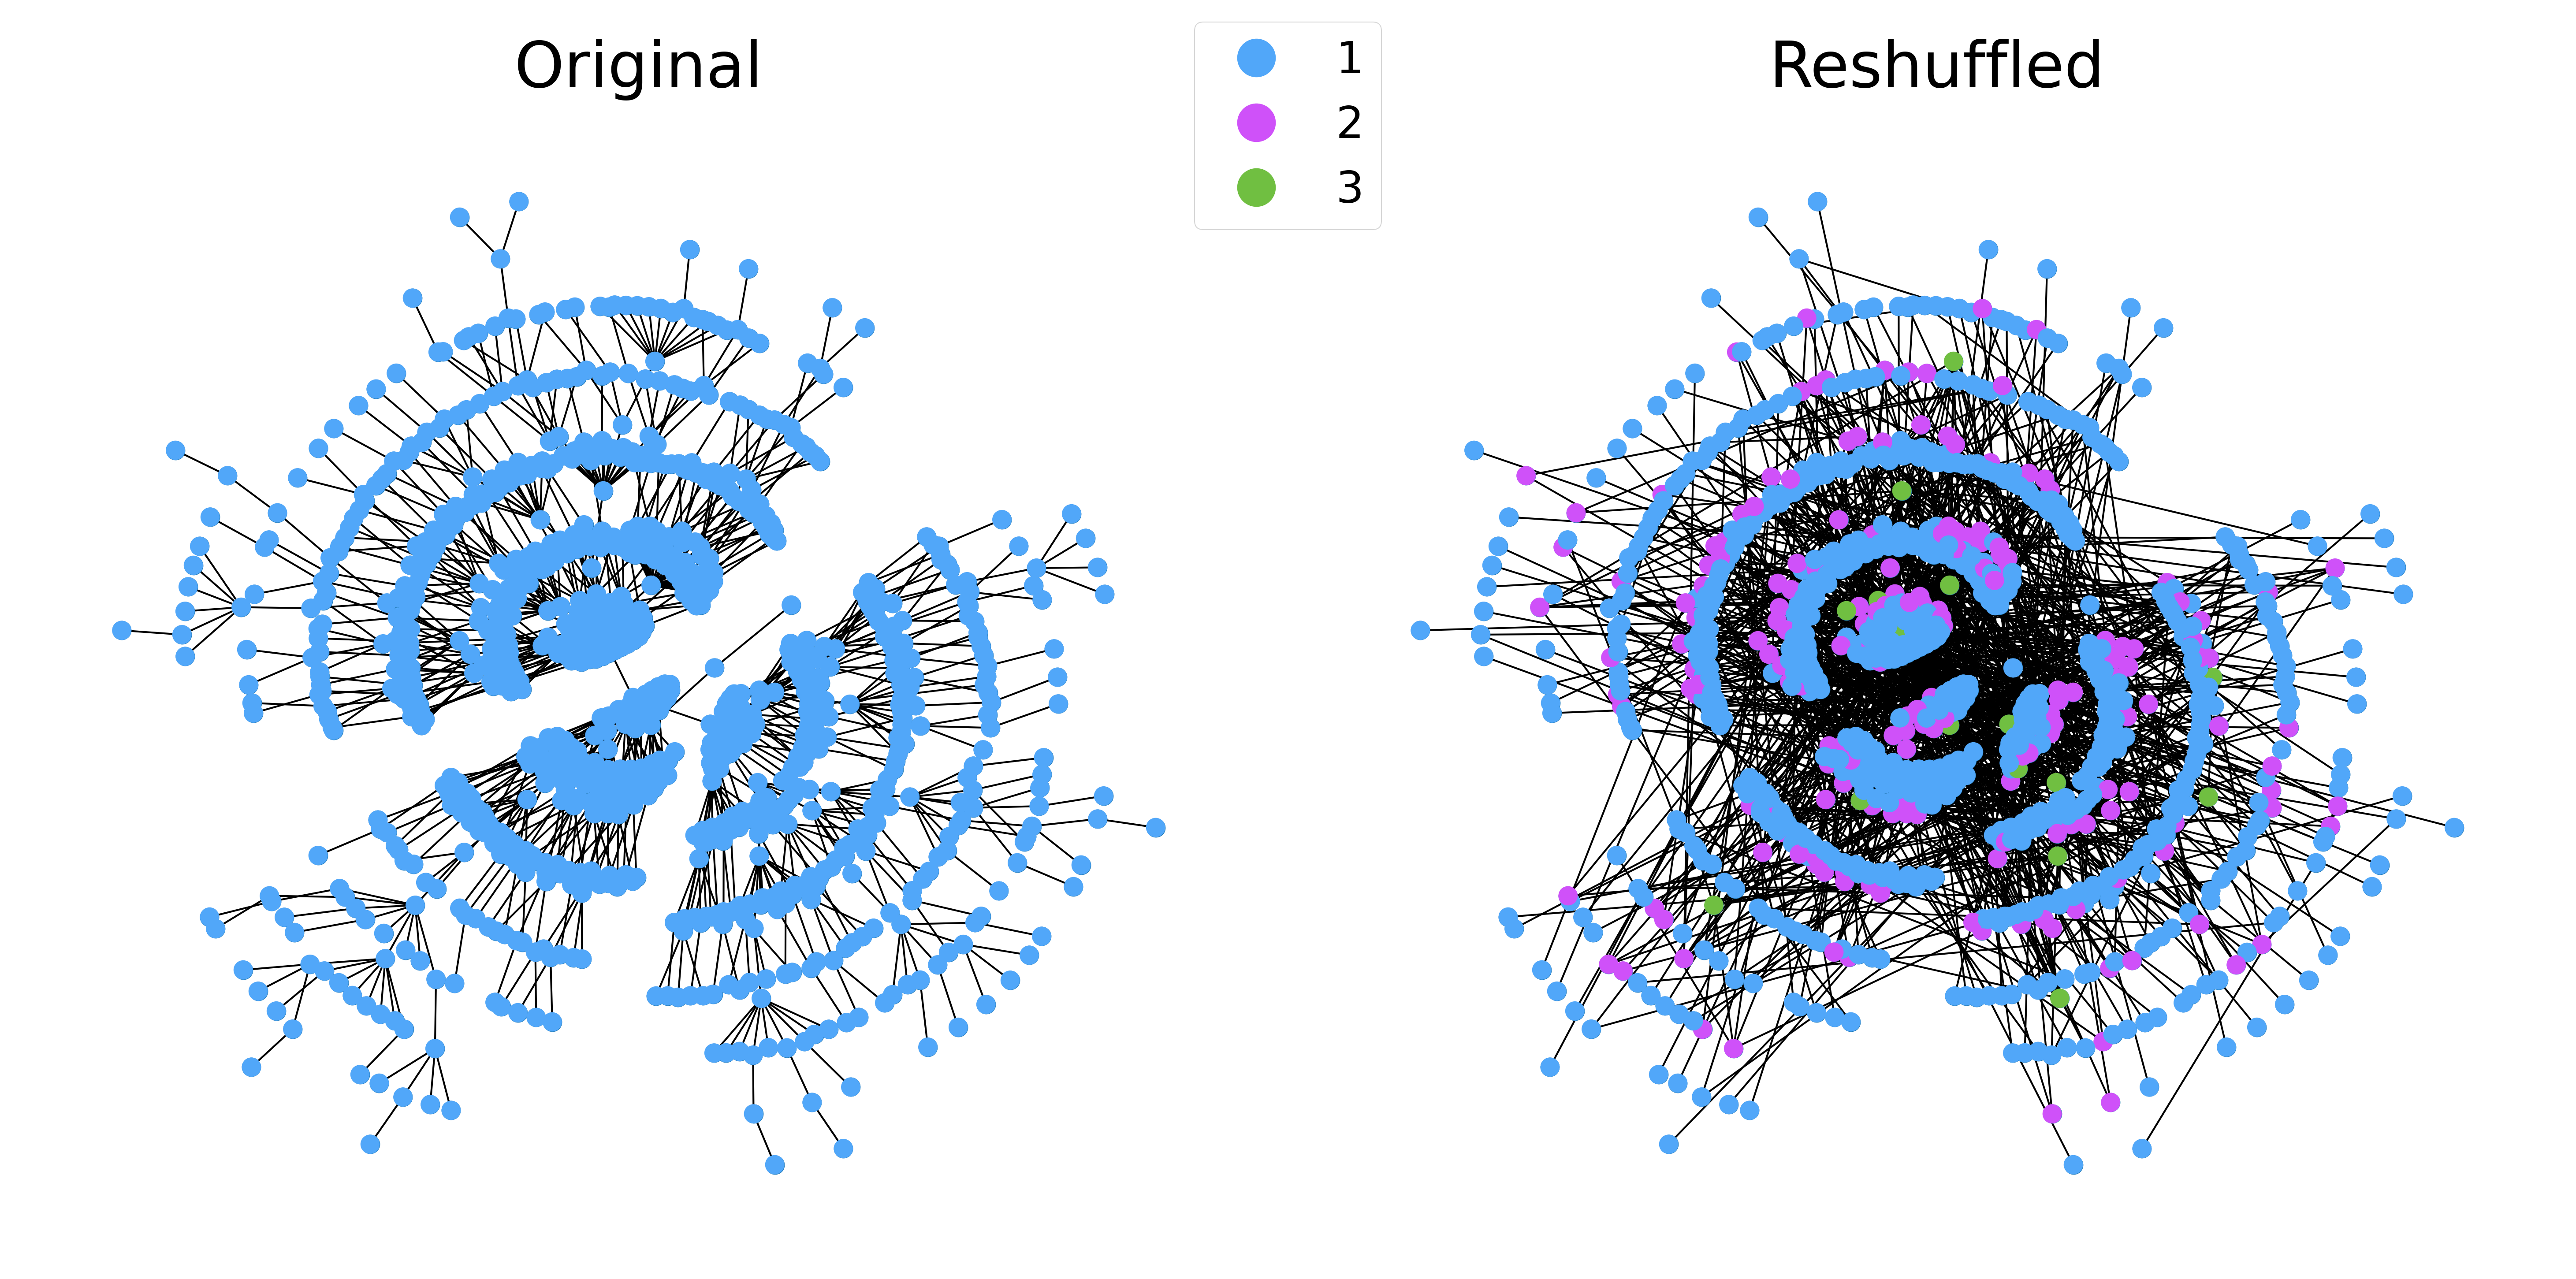

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G, pos=layout, ax=axs[0], node_size=100)
nx.draw_networkx_nodes(G, pos=layout, ax=axs[0], node_size=100, node_color=original_colors)
nx.draw(G2, pos=layout, ax=axs[1], node_size=100)
nx.draw_networkx_nodes(G2, pos=layout, ax=axs[1], node_size=100, node_color=reshuffled_colors)
axs[0].set_title('Original')
axs[1].set_title('Reshuffled')

handles, labels = axs[1].get_legend_handles_labels()
core1 = Line2D([0], [0], label='1', marker='o', markersize=20, 
         markerfacecolor=colors[0], markeredgecolor=colors[0], linestyle='')
core2 = Line2D([0], [0], label='2', marker='o', markersize=20, 
         markerfacecolor=colors[1], markeredgecolor=colors[1], linestyle='')
core3 = Line2D([0], [0], label='3', marker='o', markersize=20, 
         markerfacecolor=colors[2], markeredgecolor=colors[2], linestyle='')
handles.extend([core1, core2, core3])
fig.legend(handles=handles, loc='upper center')

In [19]:
total = total.join(pd.DataFrame.from_dict(core_numbers2, orient='index', columns=['kcore']))

Text(0, 0.5, 'Degree')

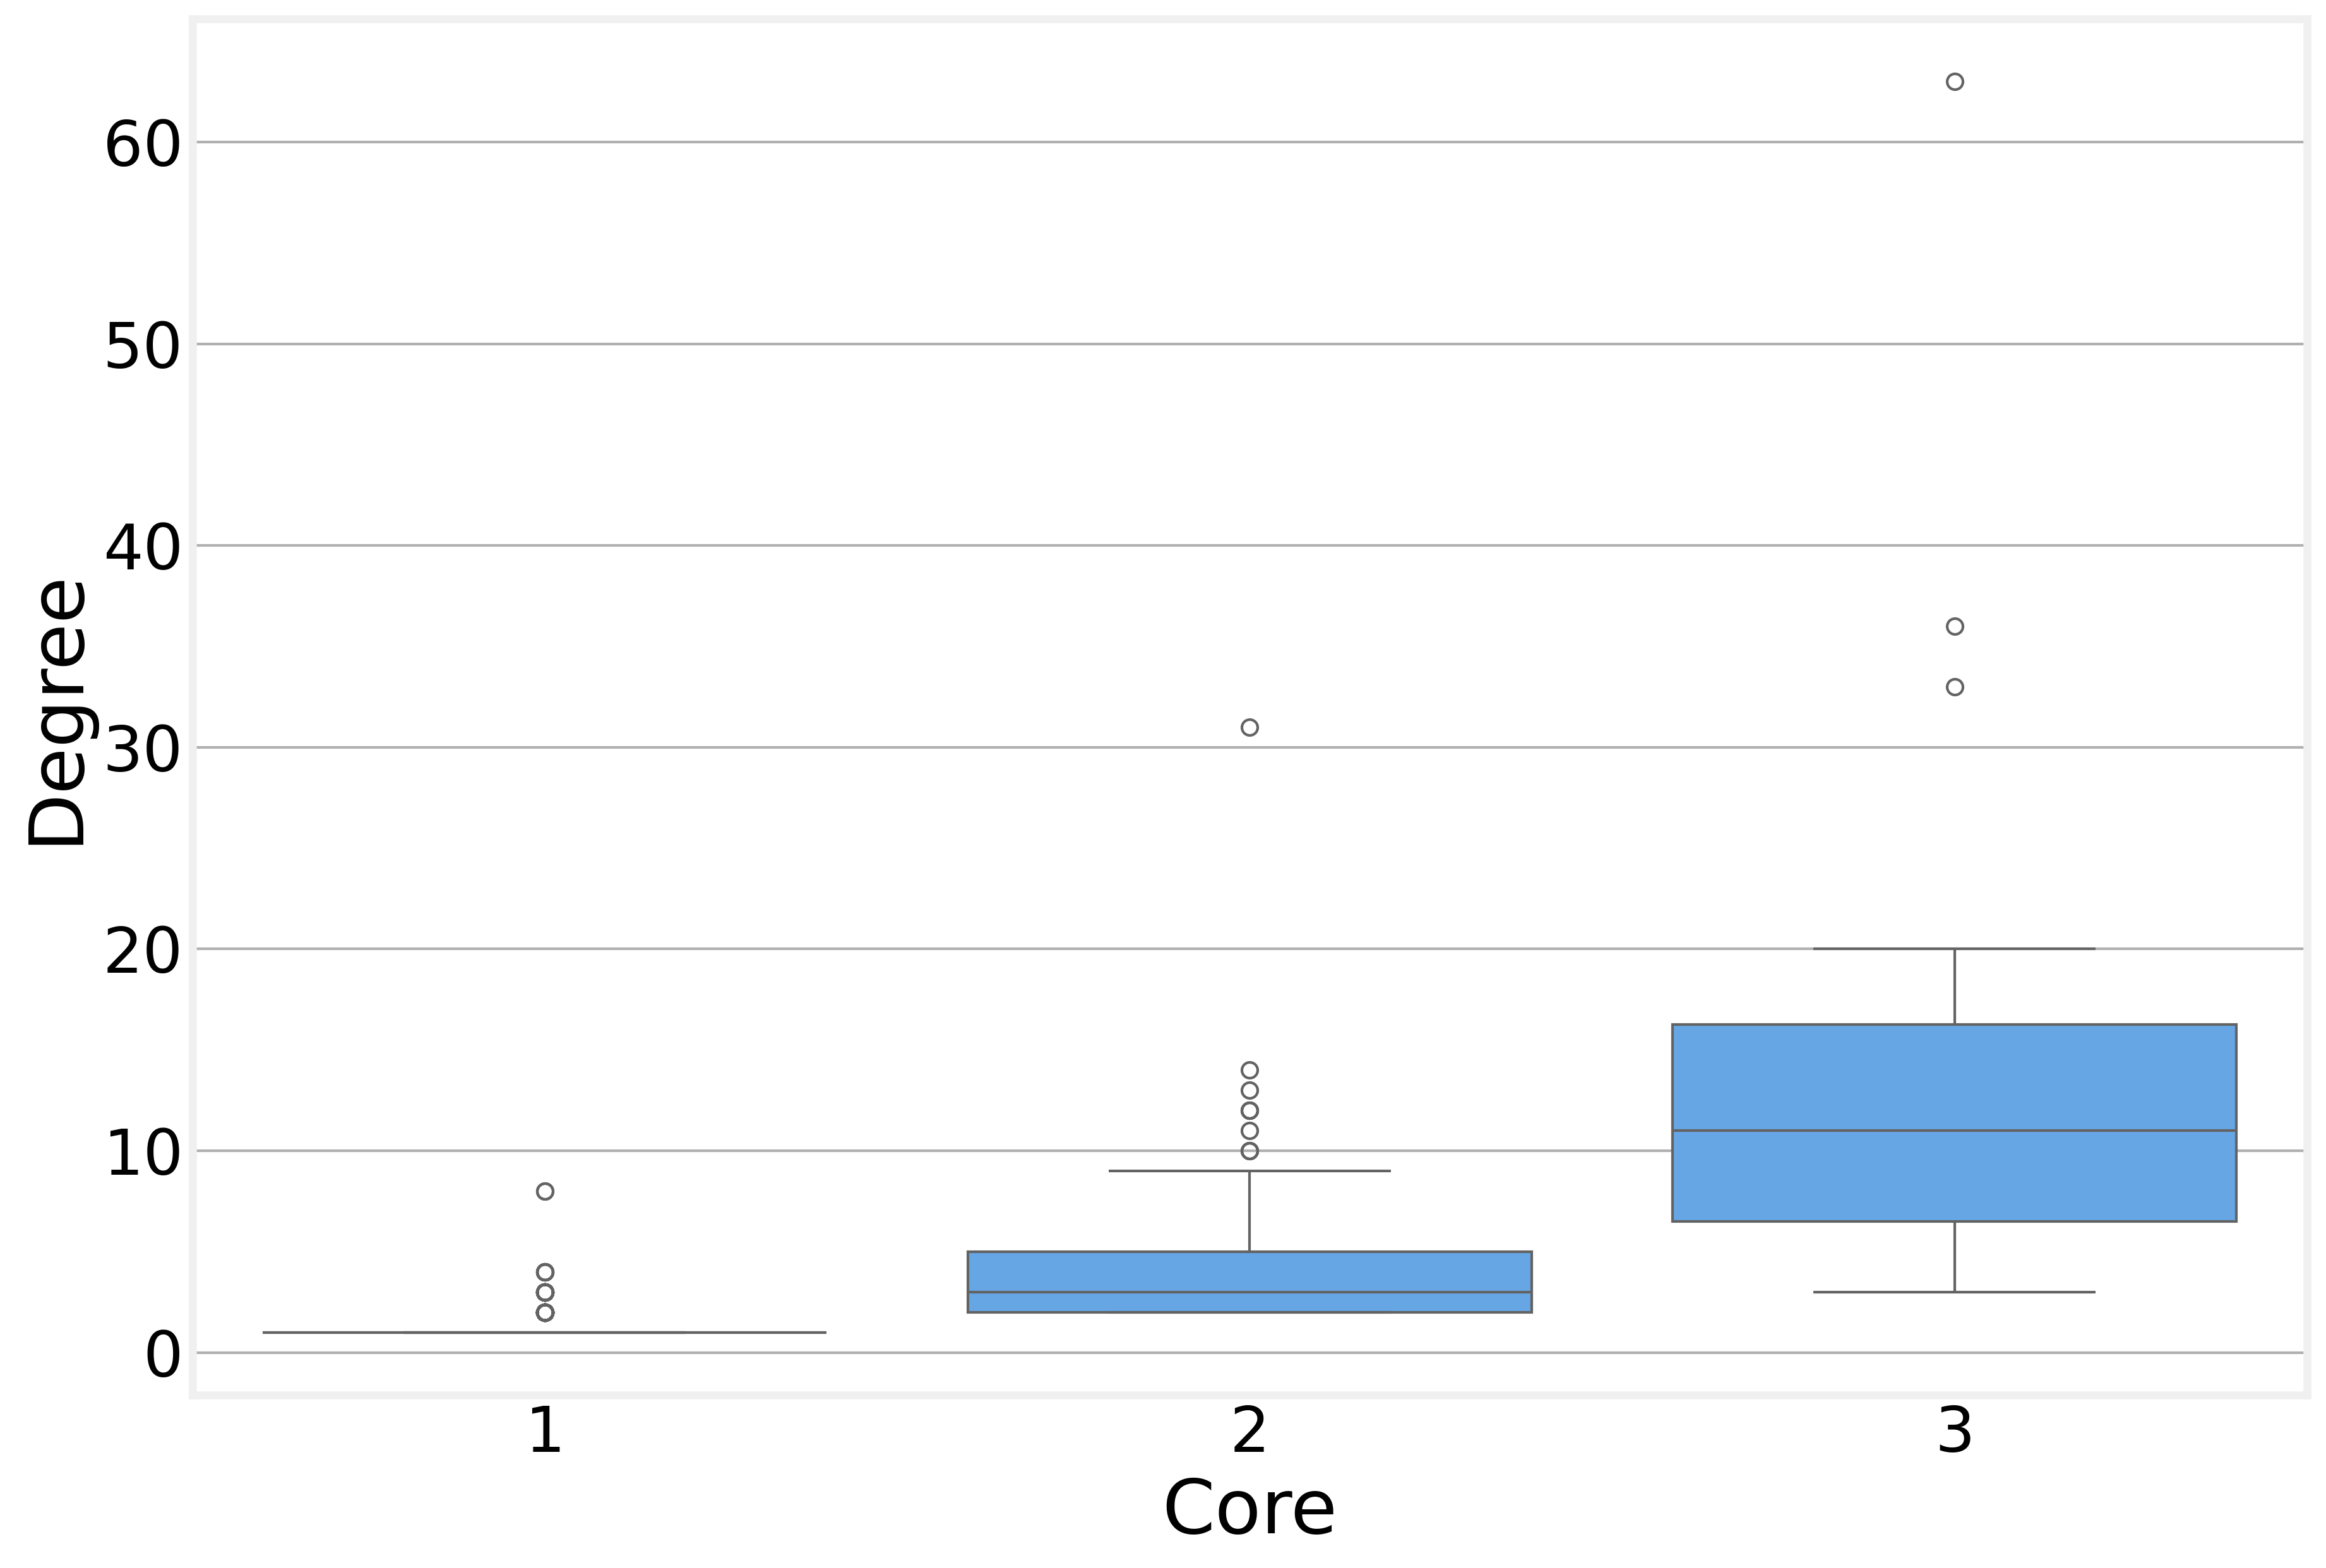

In [20]:
ax = sns.boxplot(total, y='k_reshuffled', x='kcore')
ax.set_xlabel('Core')
ax.set_ylabel('Degree')

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>